In [1]:
# 将文本文档组合为一个CSV文件
import pyprind
import pandas as pd
import os
pbar = pyprind.ProgBar(19997)

labels = {'alt.atheism':1, 
         'comp.graphics':2,
         'comp.os.ms-windows.misc':3,
         'comp.sys.ibm.pc.hardware':4,
         'comp.sys.mac.hardware':5,
         'comp.windows.x':6,
         'misc.forsale':7,
         'rec.autos':8,
         'rec.motorcycles':9,
         'rec.sport.baseball':10,
         'rec.sport.hockey':11,
         'sci.crypt':12,
         'sci.electronics':13,
         'sci.med':14,
         'sci.space':15,
         'soc.religion.christian':16,
         'talk.politics.guns':17,
         'talk.politics.mideast':18,
         'talk.politics.misc':19,
         'talk.religion.misc':20}
df = pd.DataFrame()

for l in labels.keys():
    path = './20news-19997/20_newsgroups/%s' % l
    for file in os.listdir(path):
        with open(os.path.join(path, file), 'rb') as infile:  
            txt = infile.read()
            df = df.append([[txt, labels[l]]], ignore_index=True)
            pbar.update()
df.columns = ['content', 'category']

0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:01:16


In [2]:
import numpy as np
np.random.seed(0)
df = df.reindex(np.random.permutation(df.index))
df.to_csv('./20news-19997/20_newsgroups.csv', index=False)
df = pd.read_csv('./20news-19997/20_newsgroups.csv')
df.head(3)

,content,category
0,"b""Path: cantaloupe.srv.cs.cmu.edu!crabapple.sr...",6
1,b'Xref: cantaloupe.srv.cs.cmu.edu sci.med:5897...,14
2,b'Path: cantaloupe.srv.cs.cmu.edu!magnesium.cl...,17


In [3]:
import matplotlib.pyplot as plt
#统计训练集和测试集中20种类标的个数
df['category'].value_counts().plot(kind='bar')
plt.xlabel('Category')
plt.ylabel('Text Quantity')
plt.ylim([0,1100])
plt.show()

<Figure size 640x480 with 1 Axes>

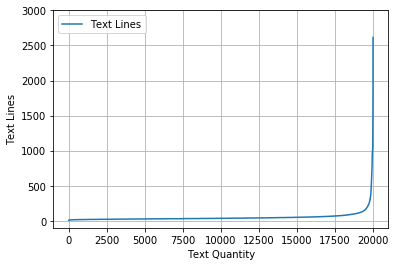

In [4]:
#统计文本文档的行数
import matplotlib.pyplot as plt
lines = []

for l in labels.keys():
    path = './20news-19997/20_newsgroups/%s' % l
    for file in os.listdir(path):
        with open(os.path.join(path, file), 'rb') as infile:  
            lines_txt = len(infile.readlines())
            lines.append(lines_txt)
            
plt.plot(sorted(lines), label='Text Lines')
plt.grid()
plt.xlabel('Text Quantity')
plt.ylabel('Text Lines')
plt.legend(loc='upper left')
plt.ylim([-100,3000])
plt.show()

In [5]:
#找出列表中位数
lst = sorted(lines)
print(len(lst))
print(lst[len(lst)//2])

19997
35


In [6]:
#清洗文本数据
import re
def preprocessor(text):
    text = re.sub('<[^>]*>', '', text)
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text)
    text = re.sub('[\W]+', ' ', text.lower())
    return text

df['content'] = df['content'].apply(preprocessor)
df.head(3)

,content,category
0,b path cantaloupe srv cs cmu edu crabapple srv...,6
1,b xref cantaloupe srv cs cmu edu sci med 58979...,14
2,b path cantaloupe srv cs cmu edu magnesium clu...,17


15    1000
14    1000
1     1000
17    1000
2     1000
18    1000
3     1000
19    1000
4     1000
20    1000
5     1000
6     1000
7     1000
8     1000
9     1000
10    1000
11    1000
12    1000
13    1000
16     997
Name: category, dtype: int64


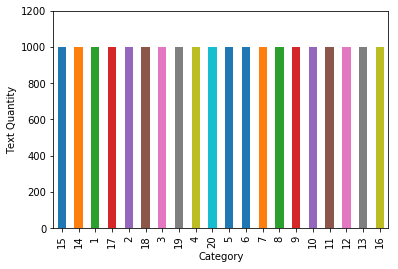

In [7]:
#获取部分数据训练和测试
df_1 = pd.DataFrame()
df_1 = df
df_1.head(3)

df_1['category'].value_counts().plot(kind='bar')
print(df_1['category'].value_counts())
#plt.grid()
plt.xlabel('Category')
plt.ylabel('Text Quantity')
plt.ylim([0,1200])
plt.show()

In [8]:
#标记文档模块
def tokenizer(text):
    return text.split()

from nltk.stem.porter import PorterStemmer
porter = PorterStemmer()
def tokenizer_porter(text):
    return [porter.stem(word) for word in text.split()]

In [9]:
#停用词移除模块
import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords
stop = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\withj\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
X = df_1.loc[:, 'content'].values
y = df_1.loc[:, 'category'].values

from sklearn.feature_extraction.text import TfidfVectorizer

# 停用词移除
new_list = []
update_list = []
for i in range(99):
    new_list = tokenizer(X[i])
    for each in new_list:
        if each not in stop:
            update_list.append(each)
    X[i] = " ".join(update_list)
    
# 词袋模型
tfidf = TfidfVectorizer(strip_accents=None,
                       lowercase=False,
                       preprocessor=None)
X = tfidf.fit_transform(X)

In [23]:
# 分割训练集和测试集
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [24]:
# 使用朴素贝叶斯模型alpha=0.01
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from time import time

clf = MultinomialNB(alpha=0.01)
start = time()
clf.fit(X_train, y_train)
end = time()
train_time = end - start
print("train time:", train_time)

y_pred = clf.predict(X_test)
start = time()
print('Accuracy: %.2f' % accuracy_score(y_test, y_pred))
end = time()
test_time = end - start
print("test time:", test_time)

train time: 0.43372368812561035
Accuracy: 0.88
test time: 0.015635967254638672


In [25]:
# 使用朴素贝叶斯模型alpha=0.1
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from time import time

clf = MultinomialNB(alpha=0.1)
start = time()
clf.fit(X_train, y_train)
end = time()
train_time = end - start
print("train time:", train_time)

y_pred = clf.predict(X_test)
start = time()
print('Accuracy: %.2f' % accuracy_score(y_test, y_pred))
end = time()
test_time = end - start
print("test time:", test_time)

train time: 0.4360380172729492
Accuracy: 0.89
test time: 0.0


In [26]:
# 使用朴素贝叶斯模型alpha=1
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from time import time

clf = MultinomialNB(alpha=1)
start = time()
clf.fit(X_train, y_train)
end = time()
train_time = end - start
print("train time:", train_time)

y_pred = clf.predict(X_test)
start = time()
print('Accuracy: %.2f' % accuracy_score(y_test, y_pred))
end = time()
test_time = end - start
print("test time:", test_time)

train time: 0.434802770614624
Accuracy: 0.88
test time: 0.0


In [27]:
# 使用朴素贝叶斯模型alpha=10
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from time import time

clf = MultinomialNB(alpha=10)
start = time()
clf.fit(X_train, y_train)
end = time()
train_time = end - start
print("train time:", train_time)

y_pred = clf.predict(X_test)
start = time()
print('Accuracy: %.2f' % accuracy_score(y_test, y_pred))
end = time()
test_time = end - start
print("test time:", test_time)

train time: 0.43963098526000977
Accuracy: 0.83
test time: 0.0


C:\Users\withj\Anaconda2\envs\python36\lib\site-packages\sklearn\learning_curve.py:22: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)


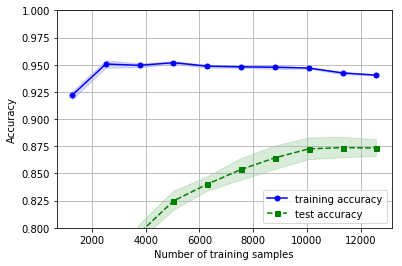

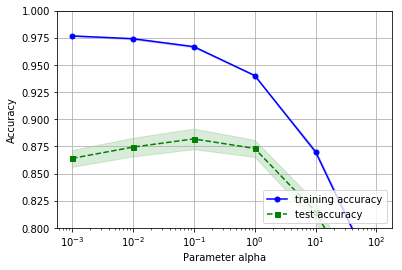

In [28]:
# 学习曲线Learning Curve
# 验证曲线validation Curve
from sklearn.cross_validation import train_test_split
import matplotlib.pyplot as plt
from sklearn.learning_curve import learning_curve
from sklearn.learning_curve import validation_curve

# 学习曲线
train_sizes,train_scores,test_scores=learning_curve(estimator=MultinomialNB(),X=X_train,y=y_train,train_sizes=np.linspace(0.1,1.0,10),cv=10,n_jobs=1)

# 统计结果
train_mean= np.mean(train_scores,axis=1)
train_std = np.std(train_scores,axis=1)
test_mean =np.mean(test_scores,axis=1)
test_std=np.std(test_scores,axis=1)

# 绘制效果
plt.plot(train_sizes,train_mean,color='blue',marker='o',markersize=5,label='training accuracy')
plt.fill_between(train_sizes,train_mean+train_std,train_mean-train_std,alpha=0.15,color='blue')
plt.plot(train_sizes,test_mean,color='green',linestyle='--',marker='s',markersize=5,label='test accuracy')
plt.fill_between(train_sizes,test_mean+test_std,test_mean-test_std,alpha=0.15,color='green')
plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8,1.0])
plt.show()

# 验证曲线
param_range=[0.001,0.01,0.1,1.0,10.0,100.0]
# 10折，验证正则化参数C
train_scores,test_scores =validation_curve(estimator=MultinomialNB(),X=X_train,y=y_train,param_name='alpha',param_range=param_range,cv=10)
#统计结果
train_mean= np.mean(train_scores,axis=1)
train_std = np.std(train_scores,axis=1)
test_mean =np.mean(test_scores,axis=1)
test_std=np.std(test_scores,axis=1)
plt.plot(param_range,train_mean,color='blue',marker='o',markersize=5,label='training accuracy')
plt.fill_between(param_range,train_mean+train_std,train_mean-train_std,alpha=0.15,color='blue')
plt.plot(param_range,test_mean,color='green',linestyle='--',marker='s',markersize=5,label='test accuracy')
plt.fill_between(param_range,test_mean+test_std,test_mean-test_std,alpha=0.15,color='green')
plt.grid()
plt.xscale('log')
plt.xlabel('Parameter alpha')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8,1.0])
plt.show()

In [29]:
# 使用决策树模型训练
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import make_scorer
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from time import time

def performance_metric(y_true, y_predict):
    score = r2_score(y_true, y_predict)
    return score

def fit_model(X, y):
    cross_validator = KFold(n_splits=3)
    regressor = DecisionTreeRegressor()
    params = {'max_depth': [1,2,3,4,5,6,7,8,9,10]}
    scoring_fnc = make_scorer(performance_metric)
    grid = GridSearchCV(estimator=regressor,
                       param_grid=params,
                       scoring=scoring_fnc,
                       cv=cross_validator)
    grid = grid.fit(X, y)
    return grid.best_estimator_

start = time() # 获得程序开始时间
optimal_reg = fit_model(X_train, y_train)
end = time() # 获得程序结束时间
train_time = end - start
print("train time:", train_time)
print("Parameter 'max_depth' is {} for the optimal model.".format(optimal_reg.get_params()['max_depth']))

y_pred = optimal_reg.predict(X_test)

def accuracy_score(truth, pred):
    """ 返回 pred 相对于 truth 的准确率 """
    # 确保预测的数量与结果的数量一致
    if len(truth) == len(pred): 
        # 计算预测准确率（百分比）
        n = 0
        for i in range(len(truth)):
            if truth[i] == pred[i]:
                n += 1
        return "Predictions have an accuracy of {:.2f}%.".format(n / len(truth) *100)
    else:
        return "Number of predictions does not match number of outcomes!"

start = time()
print("accuracy:", accuracy_score(y_test, y_pred))
end = time()
test_time = end - start
print("test time:", test_time)

train time: 198.97408986091614
Parameter 'max_depth' is 6 for the optimal model.
accuracy: Predictions have an accuracy of 8.13%.
test time: 0.03327059745788574


In [30]:
# 使用决策树模型训练
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import make_scorer
from sklearn.metrics import r2_score
from time import time

def performance_metric(y_true, y_predict):
    score = r2_score(y_true, y_predict)
    return score

start = time() # 获得程序开始时间
clf = DecisionTreeRegressor(max_depth=5)
clf.fit(X_train, y_train)
end = time() # 获得程序结束时间
train_time = end - start
print("train time:", train_time)

y_pred = optimal_reg.predict(X_test)

def accuracy_score(truth, pred):
    """ 返回 pred 相对于 truth 的准确率 """
    # 确保预测的数量与结果的数量一致
    if len(truth) == len(pred): 
        # 计算预测准确率（百分比）
        n = 0
        for i in range(len(truth)):
            if truth[i] == pred[i]:
                n += 1
        return "Predictions have an accuracy of {:.2f}%.".format(n / len(truth) *100)
    else:
        return "Number of predictions does not match number of outcomes!"

start = time()
print("accuracy:", accuracy_score(y_test, y_pred))
end = time()
test_time = end - start
print("test time:", test_time)

train time: 7.39005446434021
accuracy: Predictions have an accuracy of 8.13%.
test time: 0.03170633316040039


In [31]:
# 使用支持向量机kernel=linear
from sklearn.metrics import accuracy_score
from time import time
from sklearn.svm import SVC
clf_svc = SVC(kernel='linear',random_state=0)

start = time()
clf_svc.fit(X_train, y_train)
end = time()
train_time = end - start
print('train time:', train_time)

def accuracy_score(truth, pred):
    """ 返回 pred 相对于 truth 的准确率 """
    # 确保预测的数量与结果的数量一致
    if len(truth) == len(pred): 
        # 计算预测准确率（百分比）
        n = 0
        for i in range(len(truth)):
            if truth[i] == pred[i]:
                n += 1
        return "Predictions have an accuracy of {:.2f}%.".format(n / len(truth) *100)
    else:
        return "Number of predictions does not match number of outcomes!"

start = time()
y_pred = clf_svc.predict(X_test)
print("accuracy:", accuracy_score(y_test, y_pred))
end = time()
test_time = end - start
print("test time:", test_time)

#start = time()
#y_pred3 = clf_svc.predict(X_test)
#print('accuracy:', accuracy_score(y_test, y_pred3))
#end = time()
#test_time = end - start
#print("test time:", test_time)

train time: 657.5475723743439
accuracy: Predictions have an accuracy of 94.32%.
test time: 257.3622679710388


In [27]:
# 使用支持向量机kernel=rbf
from sklearn.metrics import accuracy_score
from time import time
from sklearn.svm import SVC
clf_svc = SVC(kernel='rbf',random_state=0)

start = time()
clf_svc.fit(X_train, y_train)
end = time()
train_time = end - start
print('train time:', train_time)

def accuracy_score(truth, pred):
    """ 返回 pred 相对于 truth 的准确率 """
    # 确保预测的数量与结果的数量一致
    if len(truth) == len(pred): 
        # 计算预测准确率（百分比）
        n = 0
        for i in range(len(truth)):
            if truth[i] == pred[i]:
                n += 1
        return "Predictions have an accuracy of {:.2f}%.".format(n / len(truth) *100)
    else:
        return "Number of predictions does not match number of outcomes!"

start = time()
y_pred = clf_svc.predict(X_test)
print("accuracy:", accuracy_score(y_test, y_pred))
end = time()
test_time = end - start
print("test time:", test_time)

#start = time()
#y_pred3 = clf_svc.predict(X_test)
#print('accuracy:', accuracy_score(y_test, y_pred3))
#end = time()
#test_time = end - start
#print("test time:", test_time)

train time: 1110.5626447200775
accuracy: Predictions have an accuracy of 4.32%.
test time: 139.51490569114685


In [32]:
# 使用支持向量机kernel=poly
from sklearn.metrics import accuracy_score
from time import time
from sklearn.svm import SVC
clf_svc = SVC(kernel='poly',random_state=0)

start = time()
clf_svc.fit(X_train, y_train)
end = time()
train_time = end - start
print('train time:', train_time)

def accuracy_score(truth, pred):
    """ 返回 pred 相对于 truth 的准确率 """
    # 确保预测的数量与结果的数量一致
    if len(truth) == len(pred): 
        # 计算预测准确率（百分比）
        n = 0
        for i in range(len(truth)):
            if truth[i] == pred[i]:
                n += 1
        return "Predictions have an accuracy of {:.2f}%.".format(n / len(truth) *100)
    else:
        return "Number of predictions does not match number of outcomes!"

start = time()
y_pred = clf_svc.predict(X_test)
print("accuracy:", accuracy_score(y_test, y_pred))
end = time()
test_time = end - start
print("test time:", test_time)

#start = time()
#y_pred3 = clf_svc.predict(X_test)
#print('accuracy:', accuracy_score(y_test, y_pred3))
#end = time()
#test_time = end - start
#print("test time:", test_time)

train time: 1176.7232239246368
accuracy: Predictions have an accuracy of 4.50%.
test time: 250.53646993637085


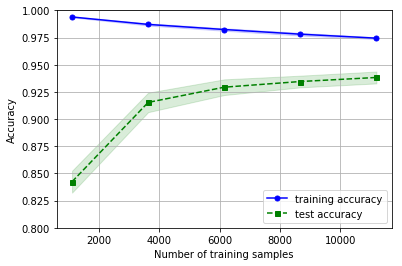

In [33]:
# 学习曲线Learning Curve
# 验证曲线validation Curve
from sklearn.cross_validation import train_test_split
import matplotlib.pyplot as plt
from sklearn.learning_curve import learning_curve
from sklearn.learning_curve import validation_curve

# 学习曲线
train_sizes,train_scores,test_scores=learning_curve(estimator=SVC(kernel='linear',random_state=0),X=X_train,y=y_train,train_sizes=np.linspace(0.1,1.0,5),cv=5,n_jobs=1)

# 统计结果
train_mean= np.mean(train_scores,axis=1)
train_std = np.std(train_scores,axis=1)
test_mean =np.mean(test_scores,axis=1)
test_std=np.std(test_scores,axis=1)

# 绘制效果
plt.plot(train_sizes,train_mean,color='blue',marker='o',markersize=5,label='training accuracy')
plt.fill_between(train_sizes,train_mean+train_std,train_mean-train_std,alpha=0.15,color='blue')
plt.plot(train_sizes,test_mean,color='green',linestyle='--',marker='s',markersize=5,label='test accuracy')
plt.fill_between(train_sizes,test_mean+test_std,test_mean-test_std,alpha=0.15,color='green')
plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8,1.0])
plt.show()